# Yield-gap (maize) analysis and plotting for Africa

A quick analysis of yield-gaps and N2O emissions for Africa.

YG data: [source](http://www.earthstat.org/yield-gaps-climate-bins-major-crops/)

This notebook produces the summary figure for the publication.

Panels:  
- Yield gap
- N2O emissions
- N2O emissions YG-closed 50%
- N2O emissions YG-closed 75%
- N2O emissions vs yield-gap
- Yield-scaled N2O emissions



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import proplot as plot
import pandas as pd
from pathlib import Path
import xarray as xr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
data_path = Path('data')

In [4]:
with xr.open_dataset("yieldgap_analysis_0083deg.nc") as ds:
    multipl = xr.where(ds.rot == 2, 2, 1)

ds

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 1080)
Coordinates:
  * lat      (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon      (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583
Data variables:
    ygap     (lat, lon) float32 ...
    ypot     (lat, lon) float32 ...
    mask     (lat, lon) bool ...
    ygapm    (lat, lon) float32 ...
    ypotm    (lat, lon) float32 ...
    area     (lat, lon) float32 ...
    rot      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    country  (lat, lon) float64 ...

In [5]:
ds['yratiom'] = (ds.ygapm / ds.ypotm)*100

## Compute N2O emission from yield gap data

In [6]:
# NEW calculation based on Global Yield Gap Atlas
def yieldgap2emis(yratio, y0=0.105, a=2.369, b=0.029, rate=None):
    eps = 10e-8
    if rate:
        return y0 + a*np.exp(-b*(1-rate)*yratio)
        #return xr.where(ygap < (rate*ypot), y0 + a*np.power((1-rate)*ypot, b), 
        #                                    y0 + a*np.power(ygap+eps, b))
    else:
        return y0 + a*np.exp(-b*yratio)

In [7]:
# replace ygapm with yratiom for new formula
ds["n2o_50p"] = yieldgap2emis(ds.yratiom, rate=0.5) * multipl
ds["n2o_75p"] = yieldgap2emis(ds.yratiom, rate=0.75) * multipl
ds["n2o_100p"] = yieldgap2emis(ds.yratiom, rate=1) * multipl
ds["n2o"] = yieldgap2emis(ds.yratiom, rate=0) * multipl

In [8]:
# limit 
for v in ["n2o", "n2o_50p", "n2o_75p", "n2o_100p"]:
    ds[v] = ds[v].where(ds.ygapm > 10e-8)

## Load and preprocess EDGAR data

In [9]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            # scale units and convert from N2O to N2O-N 
            da = da * 3600 * 24 * 365 * 10000 * (28/44)
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    # make sure we have clean 2 digit lons
    da = da.assign_coords(lon=da.lon.round(2))
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

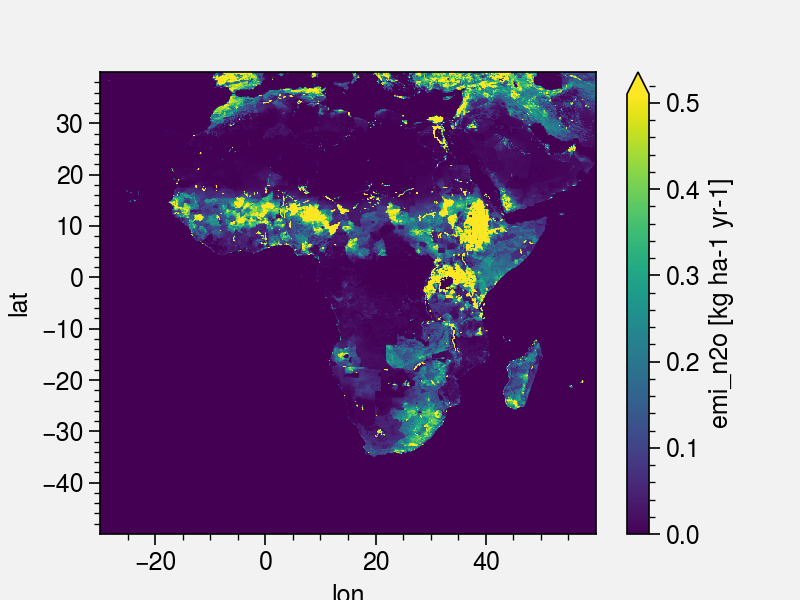

In [10]:
with xr.open_dataset(data_path / "v50_N2O_2015_AGS.0.1x0.1.nc") as ds2:
    ds2 = preprocess_edgar_nc(ds2.emi_n2o)
    ds2 = ds2.sel(lat=slice(-50, 40), lon=slice(-30,60))

    #interpolate into the higher resolution grid
    ds2 = ds2.interp(lat=ds.lat, lon=ds.lon)
    ds2.plot(figsize=(4,3), robust=True);

In [11]:
# read subsahara mask
with xr.open_dataset(data_path / "mask.nc") as mask:
    ssa = mask.subsahara.interp(lat=ds.lat, lon=ds.lon)

## Prepare yield gap data for scatter plots

In [12]:
# scatter plot data per continent
d_marker = {'SSA': 'o', 'LAM': '^',  'Australia':'s', 'SE Asia': 'D'}
d_color = {'SSA, LAM, AUS': 'black', 'SEA': 'lightgray'}


df = pd.read_csv(data_path / "Input data_relative YGs.csv")
df.columns = ['n2o', 'yieldscaled_n2o', 'yieldgap', 'yieldgap_percent', 'continent']
df['group']  = df['continent'].apply(lambda x: 'SSA, LAM, AUS' if x in ['SSA', 'LAM', 'Australia'] else 'SEA') 
df['color']  = df['group'].map(d_color)
df['marker'] = df['continent'].map(d_marker)
df.head()

,n2o,yieldscaled_n2o,yieldgap,yieldgap_percent,continent,group,color,marker
0,0.051,0.017,7.3,71.5,SSA,"SSA, LAM, AUS",black,o
1,0.116,0.032,6.5,64.1,SSA,"SSA, LAM, AUS",black,o
2,0.111,0.030,6.4,63.2,SSA,"SSA, LAM, AUS",black,o
3,0.142,0.032,5.7,55.8,SSA,"SSA, LAM, AUS",black,o
4,0.277,0.061,5.6,55.3,SSA,"SSA, LAM, AUS",black,o


In [13]:
# number of datapoints per region
dict(df.continent.value_counts())

{'SSA': 61, 'SE Asia': 34, 'LAM': 18, 'Australia': 4}

In [14]:
# confidence band data/ regression model (sourced from Sonjas model fitting)
df1 = pd.read_csv(data_path / "confidence_bands_yieldgap_cumn2o.csv")
df2 = pd.read_csv(data_path / "confidence_bands_yieldgap_ysemis.csv")
df1.head()

,x,y,lw_95c,up_95c,lw_95p,up_95p
0,0.982422,2.406961,1.930581,2.883342,1.099649,3.714274
1,1.365756,2.381209,1.919215,2.843203,1.079070,3.683348
2,1.749089,2.355745,1.907710,2.803780,1.058493,3.652997
3,2.132423,2.330566,1.896065,2.765067,1.037926,3.623206
4,2.515757,2.305668,1.884280,2.727057,1.017376,3.593960


## Plotting

In [15]:
colors = 'sunset'
colors_ls = 'marine' #'Purples' #'RdPu'
VMAX=4
LEVELS=[0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]

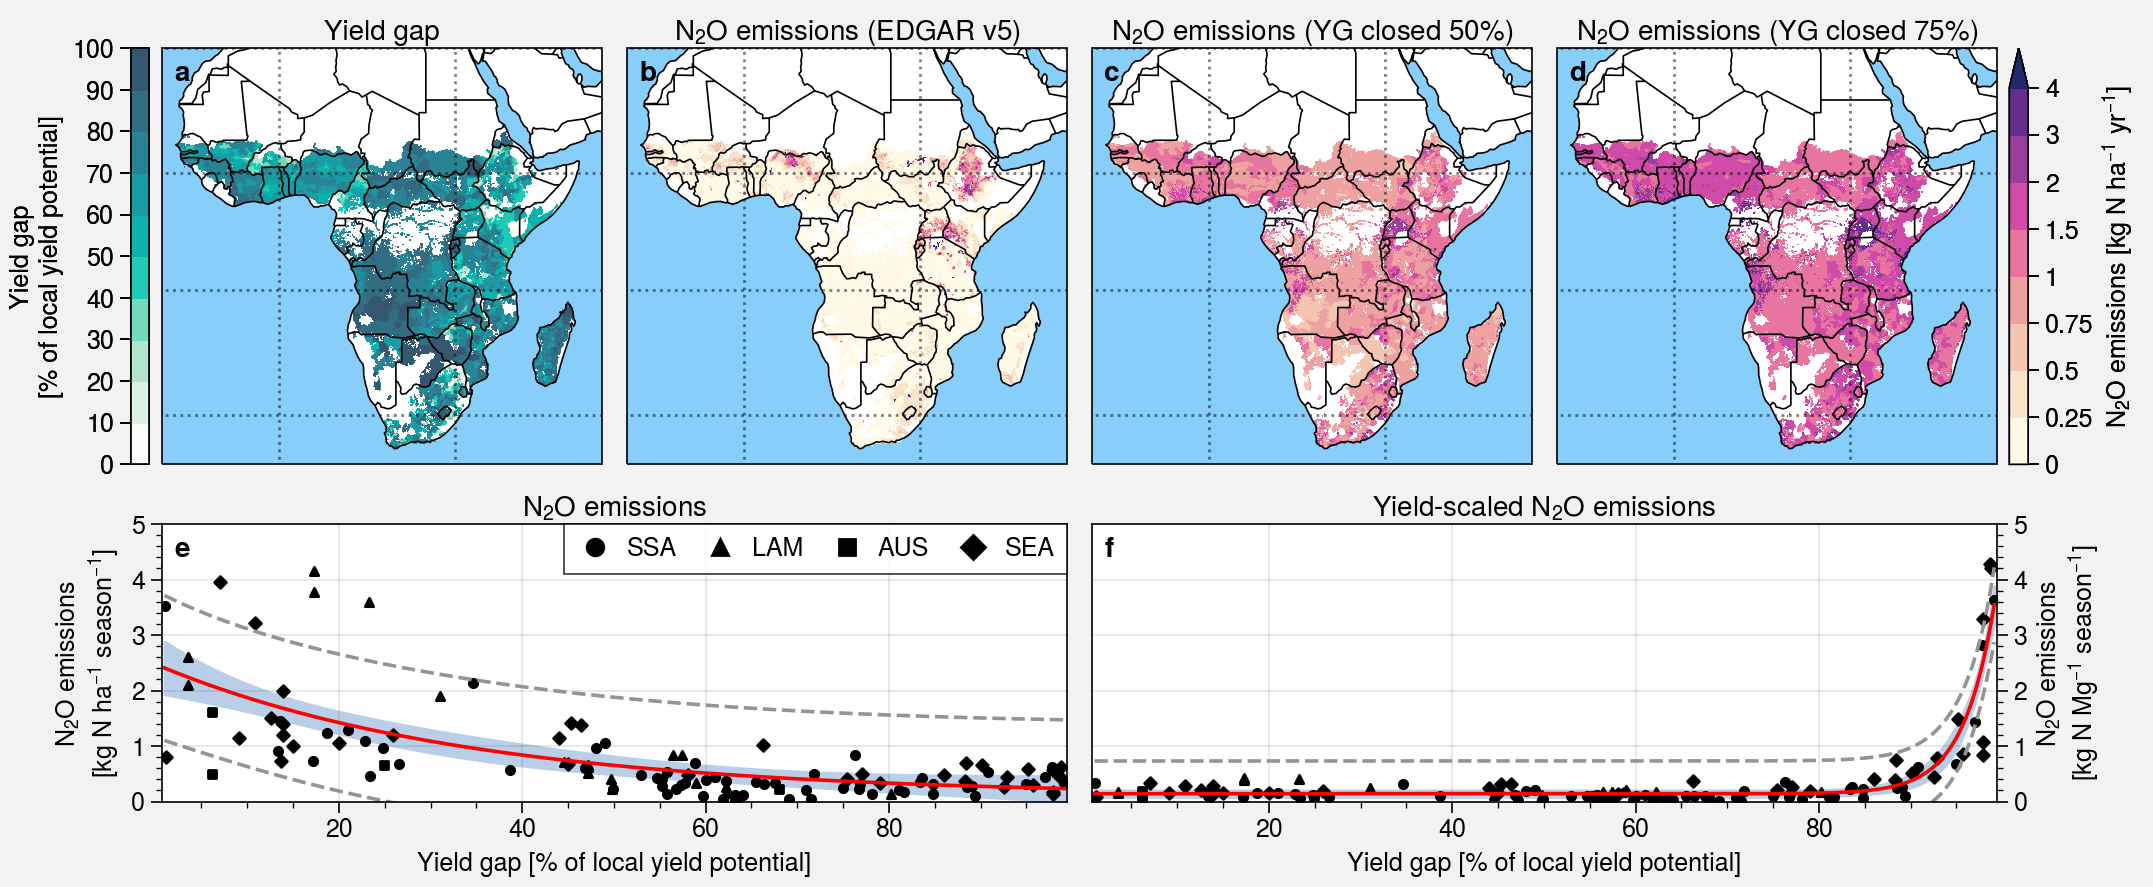

In [24]:
f, axs = plot.subplots([[1, 2, 3, 4], [5, 5, 6, 6]], 
                       hratios=(1.5, 1.),
                       axwidth=2.2,
                       share=0,
                       proj={k:'merc' for k in [1,2,3,4]}) #, share=3)

axs.format(abc=True, 
           abcloc='ul',
           abcborder=False)

# top row
for i, var in enumerate(['n2o', 'n2o_50p', 'n2o_75p']):
    m = axs[i+1].pcolormesh(
        (ds2 * ssa).where(ds[var] > -1) if var == 'n2o' else ds[var].where(ds[var] > -1) * ssa,
        cmap=colors,
        colorbar='r' if i==2 else None, 
        colorbar_kw={'label': 'N$_2$O emissions [kg N ha$^{-1}$ yr$^{-1}$]', 'width': '0.75em'} if i==2 else None, 
        vmin=0, vmax=VMAX, levels=LEVELS,
        extend='max',
        linewidth=0.7, #color='gray7'
    )

# livestock units
axs[0].pcolormesh(
    ds.yratiom.where(ds.yratiom>-1), 
    cmap=colors_ls,
    colorbar='l', 
    linewidth=0.7,
    cmap_kw={'right': 0.8},
    #colorbar_kw={'label': 'Yield gap [Mg ha$^{-1}$ season$^{-1}$]', 'width': '0.75em'}, 
    colorbar_kw={'label': 'Yield gap\n[% of local yield potential]', 'width': '0.75em'}, 
    #vmin=0, vmax=12, levels=[0, 2, 4, 6, 8, 10],
    #extend='max',
)

# scatter plots with uncertainties
axs[4].fill_between(df1.x, df1.lw_95c, df1.up_95c, color="#b9cfe7", edgecolor="", label='95% confidence')
axs[4].plot(df1.x, df1.lw_95p, linestyle='dashed', c='gray', label='95% pred. uncertainty')
axs[4].plot(df1.x, df1.up_95p, linestyle='dashed', c='gray')
axs[4].plot(df1.x, df1.y, c='red')
for idx, df_region in df.groupby("marker"):
    axs[4].scatter(df_region.yieldgap_percent, df_region.n2o, c='black', marker=idx) #, marker=df.marker) # 'black')

axs[5].fill_between(df2.x, df2.lw_95c, df2.up_95c, color="#b9cfe7", edgecolor="", label='95% confidence')
axs[5].plot(df2.x, df2.lw_95p, linestyle='dashed', c='gray', label='95% pred. uncertainty')
axs[5].plot(df2.x, df2.up_95p, linestyle='dashed', c='gray')
axs[5].plot(df2.x, df2.y, c='red')
for idx, df_region in df.groupby("marker"):
    axs[5].scatter(df_region.yieldgap_percent, df_region.yieldscaled_n2o, c='black', marker=idx) #, marker=df.marker) # 'black')


labels = ["Yield gap", 
          "N$_2$O emissions (EDGAR v5)", 
          "N$_2$O emissions (YG closed 50%)", 
          "N$_2$O emissions (YG closed 75%)",
          "N$_2$O emissions",
          "Yield-scaled N$_2$O emissions"]

# maps
for i in range(4):
    axs[i].format(
        title=labels[i],
        lonlim=(-20, 55), latlim=(-37, 30),
        borders=True,
        coast=True,
        ocean=True,
        oceancolor='lightskyblue',
    )

# data panels
for i in range(4, 6):
    axs[i].format(
        title=labels[i],
        ylim=(0, 5),
        xlabel='Yield gap [% of local yield potential]'
    )

# custom legend for scatter plot
elements = [Line2D([], [], marker='o', color='black', label='SSA', ms=6, ls='None'),
            Line2D([], [], marker='^', color='black', label='LAM', ms=6, ls='None'),
            Line2D([], [], marker='s', color='black', label='AUS', ms=6, ls='None'),
            Line2D([], [], marker='D', color='black', label='SEA', ms=6, ls='None')]
            #Line2D([], [], marker='D', color='lightgray', label='SEA (excl.)', ms=6, ls='None')]
            #Patch(facecolor='lightgray', edgecolor='None', label='not used')]

# Create the figure
axs[4].legend(handles=elements, ncols=5, facecolor='white')

axs[4].format(ylabel='N$_2$O emissions\n[kg N ha$^{-1}$ season$^{-1}$]',
             ylim=(0, 5))
axs[5].format(ylabel='N$_2$O emissions\n[kg N Mg$^{-1}$ season$^{-1}$]',
              ytickloc='right',
              yticklabelloc='right')

In [25]:
f.savefig("figure_panelplot_yieldgap_emission.png", dpi=400, facecolor='w')

## Extra analysis: per country data

In [19]:
tmw_lu = pd.read_csv(data_path / "tmworld" / "tmworld_countries_lut.txt", delim_whitespace=True, header=None)
tmw_lu.columns = ['id', 'name']

lut = {k:v for k, v in zip(tmw_lu.id, tmw_lu.name)}

In [20]:
with xr.Dataset() as percountry:
    for v in ["n2o", "n2o_50p", "n2o_75p", "ygapm", "ypotm"]:
        percountry[v] = (ds[v]*ssa).where(ds.n2o > -1).groupby(ds.country).mean()
    percountry['edgar'] = (ds2 * ssa).where(ds.n2o > -1).groupby(ds.country).mean()
    percountry = percountry.to_dataframe().reset_index()
    percountry["country"] = percountry.country.astype('int')
    percountry["cname"] = percountry.country.apply(lambda x: lut[x])
    percountry['area_km2'] = (ds.area * ssa).where(ds.n2o > -1).groupby(ds.country).sum() * 0.01

    percountry = percountry.dropna().drop('country', axis=1).round(3)
    percountry['area_km2'] = percountry.area_km2.round(0).astype('int')
    percountry = percountry[['cname', 'area_km2', 'edgar', 'n2o', 'n2o_50p', 'n2o_75p', 'ygapm', 'ypotm']]
    percountry.to_csv("table_percountry_stats.csv", index=False)

percountry

/Users/werner-ch/.pyenv/versions/miniconda3-latest/envs/datascience/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,cname,area_km2,edgar,n2o,n2o_50p,n2o_75p,ygapm,ypotm
1,Angola,955234,0.034,0.338,0.880,1.537,4.241,4.840
2,Botswana,214254,0.051,0.249,0.688,1.280,3.864,3.987
3,Burundi,23755,0.425,0.404,0.982,1.642,5.075,6.352
4,Cameroon,222331,0.146,0.786,1.402,1.914,2.011,4.125
6,Central African Republic,437454,0.103,0.354,0.872,1.455,2.963,3.776
7,Chad,242948,0.125,0.375,0.900,1.476,2.317,3.043
10,Congo,75056,0.032,0.387,0.974,1.654,3.167,3.869
11,Democratic Republic of the Congo,899038,0.020,0.369,0.913,1.531,3.586,4.480
12,Benin,104101,0.219,0.504,1.084,1.651,2.239,3.504
14,Ethiopia,522271,0.789,0.593,1.168,1.715,3.386,5.272
